# Zan Merrill - MKT 382 - October 2025
### This code was generated with the assistance of chatGPT

In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams

# I pulled data from these two websites

### Fertility: https://www.cdc.gov/nchs/hus/data-finder.htm?year=2020-2021&table=Table%20Brth
### Inflation: https://fred.stlouisfed.org/series/FPCPITOTLZGUSA

### It was then easier for me to manually adjust it into the table I wanted.
#### Inflation data was recorded on the first of a given year, so I used that as the previous year's inflation



In [2]:
# CSV data file
csv_path = "https://raw.githubusercontent.com/AHMerrill/MKT-382/main/birth_inflation.csv"

# Font file
font_path = "https://raw.githubusercontent.com/AHMerrill/MKT-382/main/HussarBold.otf"


In [3]:
bi = pd.read_csv(csv_path)
bi.head()

,year,fertility_rate,inflation_rate
0,1980,68.4,10.334715
1,1981,67.3,6.131427
2,1982,67.3,3.212435
3,1983,65.7,4.300535
4,1984,65.5,3.545644


In [4]:
# Make sure the data is sorted by year first
bi = bi.sort_values("year").copy()

# Create multiple lag variables (1 to 5 years)
for lag in range(1, 6):
    bi[f"inflation_lag{lag}"] = bi["inflation_rate"].shift(lag)

# Drop rows with missing values in any of the new lag columns
bi = bi.dropna(subset=[f"inflation_lag{lag}" for lag in range(1, 6)])

bi.head()

,year,fertility_rate,inflation_rate,inflation_lag1,inflation_lag2,inflation_lag3,inflation_lag4,inflation_lag5
5,1985,66.3,1.898048,3.545644,4.300535,3.212435,6.131427,10.334715
6,1986,65.4,3.664563,1.898048,3.545644,4.300535,3.212435,6.131427
7,1987,65.8,4.077741,3.664563,1.898048,3.545644,4.300535,3.212435
8,1988,67.3,4.827003,4.077741,3.664563,1.898048,3.545644,4.300535
9,1989,69.2,5.397956,4.827003,4.077741,3.664563,1.898048,3.545644


In [5]:
# 1-year lag model
model = smf.ols("fertility_rate ~ inflation_lag1 + year", data=bi).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         fertility_rate   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     16.92
Date:                Tue, 07 Oct 2025   Prob (F-statistic):           9.71e-06
Time:                        01:00:52   Log-Likelihood:                -73.629
No. Observations:                  35   AIC:                             153.3
Df Residuals:                      32   BIC:                             157.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        323.1531     86.275      3.

In [6]:
# Partial out 'year' from fertility_rate
bi["fert_resid"] = smf.ols("fertility_rate ~ year", data=bi).fit().resid

# Partial out 'year' from inflation_lag1
bi["infl_resid"] = smf.ols("inflation_lag1 ~ year", data=bi).fit().resid

# Regress residuals (no intercept)
model_fwl = sm.OLS(bi["fert_resid"], bi["infl_resid"]).fit()

print(model_fwl.summary())


                                 OLS Regression Results                                
Dep. Variable:             fert_resid   R-squared (uncentered):                   0.136
Model:                            OLS   Adj. R-squared (uncentered):              0.111
Method:                 Least Squares   F-statistic:                              5.367
Date:                Tue, 07 Oct 2025   Prob (F-statistic):                      0.0267
Time:                        01:00:55   Log-Likelihood:                         -73.629
No. Observations:                  35   AIC:                                      149.3
Df Residuals:                      34   BIC:                                      150.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

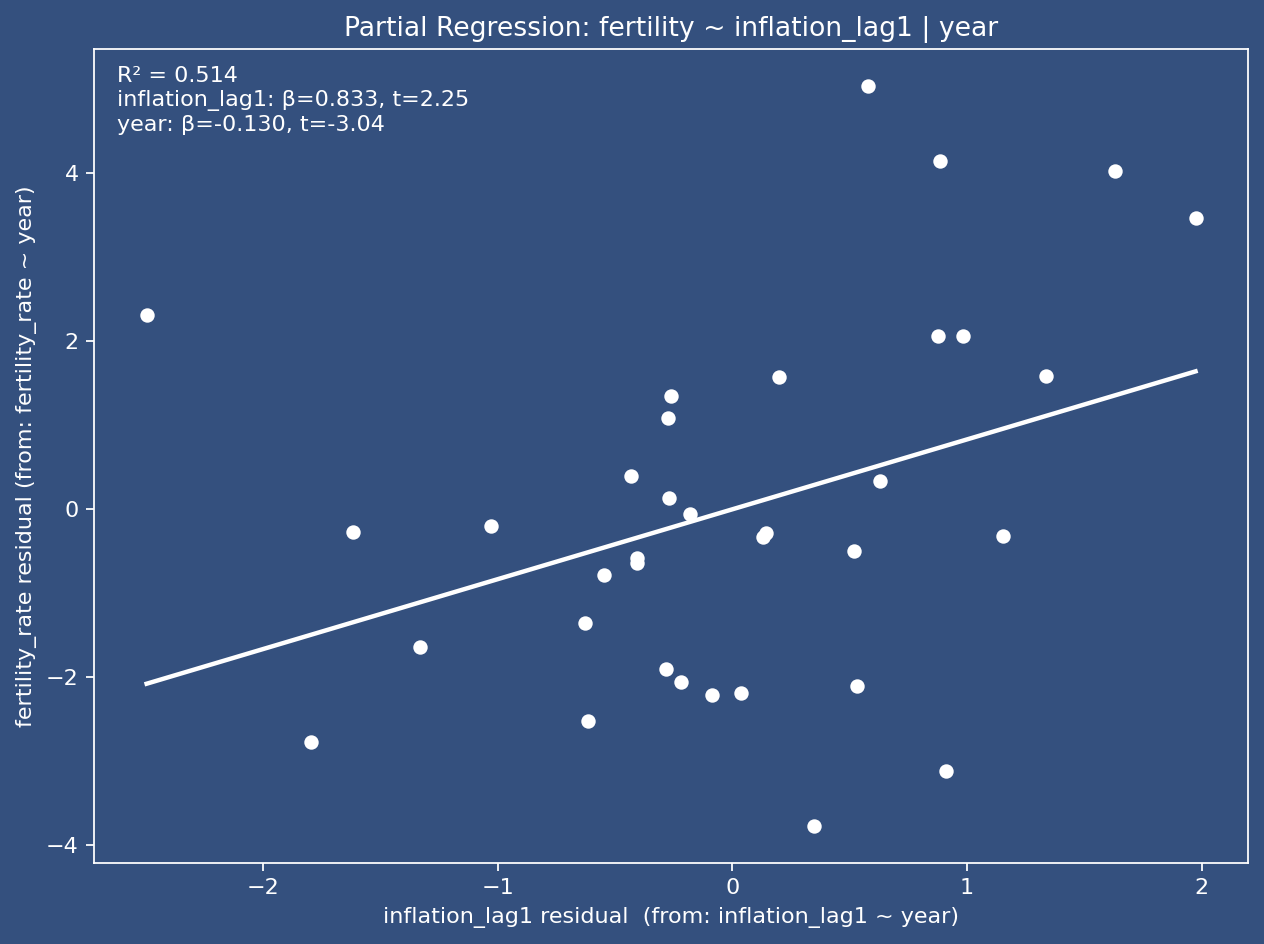

In [7]:
# --- Font setup (optional but robust) ---
try:
    font_manager.fontManager.addfont(font_path)
except Exception:
    pass

available = {f.name for f in font_manager.fontManager.ttflist}
if "Hussar Bold" in available:
    rcParams["font.family"] = "Hussar Bold"
elif "HussarBold" in available:
    rcParams["font.family"] = "HussarBold"
else:
    rcParams["font.family"] = "DejaVu Sans"  # fallback

# --- Colors / styling ---
BG = "#34507e"
FG = "white"

def style_axes(ax):
    ax.set_facecolor(BG)
    for sp in ax.spines.values():
        sp.set_color(FG)
    ax.tick_params(colors=FG)
    ax.xaxis.label.set_color(FG)
    ax.yaxis.label.set_color(FG)
    ax.title.set_color(FG)

# ===== 1) Fit your full model =====
model = smf.ols("fertility_rate ~ inflation_lag1 + year", data=bi).fit()

# ===== 2) Residualize on 'year' (FWL vectors for plotting) =====
fert_resid = smf.ols("fertility_rate ~ year", data=bi).fit().resid
infl_resid = smf.ols("inflation_lag1 ~ year", data=bi).fit().resid

# Make sure residual series are named so params are accessible by name
fert_resid = pd.Series(fert_resid, name="fert_resid")
infl_resid = pd.Series(infl_resid, name="infl_resid")

# Fit a simple line for the scatter: fert_resid ~ const + infl_resid
X_line = sm.add_constant(infl_resid)  # columns: ['const', 'infl_resid']
line = sm.OLS(fert_resid, X_line).fit()
b0 = line.params["const"]
b1 = line.params["infl_resid"]

# ===== 3) Plot: partial regression scatter + fitted line =====
plt.close("all")
fig, ax = plt.subplots(figsize=(8, 6), dpi=160)
fig.patch.set_facecolor(BG)
style_axes(ax)

# Scatter
ax.scatter(infl_resid, fert_resid, s=30, color=FG)

# Trend line over the scatter range
xg = np.linspace(infl_resid.min(), infl_resid.max(), 200)
yg = b0 + b1 * xg
ax.plot(xg, yg, color=FG, linewidth=2)

ax.set_xlabel("inflation_lag1 residual  (from: inflation_lag1 ~ year)")
ax.set_ylabel("fertility_rate residual (from: fertility_rate ~ year)")
ax.set_title("Partial Regression: fertility ~ inflation_lag1 | year")

# Annotate stats (use full-model β & t and full-model R²)
text_lines = [
    f"R² = {model.rsquared:.3f}",
    f"inflation_lag1: β={model.params['inflation_lag1']:.3f}, t={model.tvalues['inflation_lag1']:.2f}",
    f"year: β={model.params['year']:.3f}, t={model.tvalues['year']:.2f}",
]
ax.text(
    0.02, 0.98, "\n".join(text_lines),
    transform=ax.transAxes, ha="left", va="top",
    color=FG, fontsize=10, linespacing=1.25
)

plt.tight_layout()
plt.show()


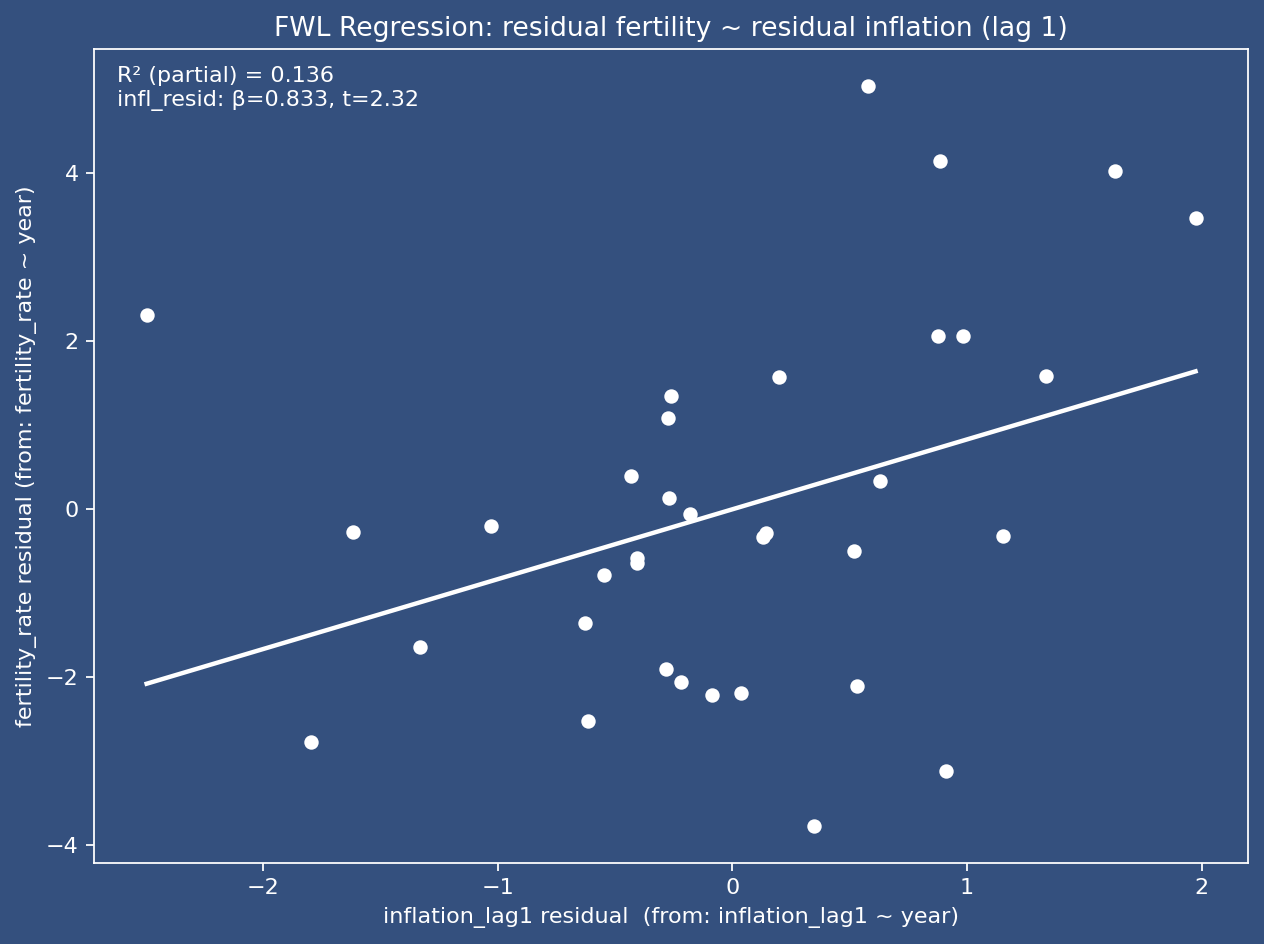

In [8]:
# ---------- Font (optional) ----------
try:
    font_manager.fontManager.addfont("HussarBold.otf")
except Exception:
    pass

avail = {f.name for f in font_manager.fontManager.ttflist}
if "Hussar Bold" in avail:
    rcParams["font.family"] = "Hussar Bold"
elif "HussarBold" in avail:
    rcParams["font.family"] = "HussarBold"
else:
    rcParams["font.family"] = "DejaVu Sans"  # fallback

# ---------- Colors / style ----------
BG = "#34507e"
FG = "white"

def style_axes(ax):
    ax.set_facecolor(BG)
    for sp in ax.spines.values():
        sp.set_color(FG)
    ax.tick_params(colors=FG)
    ax.xaxis.label.set_color(FG)
    ax.yaxis.label.set_color(FG)
    ax.title.set_color(FG)

# ---------- FWL residuals ----------
# (You already computed these, but ensure names are set)
fert_resid = pd.Series(bi["fert_resid"], name="fert_resid")
infl_resid = pd.Series(bi["infl_resid"], name="infl_resid")

# Refit the exact same model you ran: no intercept
model_fwl = sm.OLS(fert_resid, infl_resid).fit()

# For the fitted line (no intercept): y_hat = beta * x
beta = model_fwl.params["infl_resid"]

# Create a smooth x-grid and predict using the *same* no-intercept model
xg = np.linspace(infl_resid.min(), infl_resid.max(), 200)
xg_series = pd.Series(xg, name="infl_resid")
yg = model_fwl.predict(xg_series)  # equals beta * xg

# ---------- Plot ----------
plt.close("all")
fig, ax = plt.subplots(figsize=(8, 6), dpi=160)
fig.patch.set_facecolor(BG)
style_axes(ax)

# Scatter of residuals
ax.scatter(infl_resid, fert_resid, s=30, color=FG)

# FWL fitted line (no intercept)
ax.plot(xg, yg, color=FG, linewidth=2)

ax.set_xlabel("inflation_lag1 residual  (from: inflation_lag1 ~ year)")
ax.set_ylabel("fertility_rate residual (from: fertility_rate ~ year)")
ax.set_title("FWL Regression: residual fertility ~ residual inflation (lag 1)")

# ---------- Annotate stats (white text) ----------
lines = [
    f"R² (partial) = {model_fwl.rsquared:.3f}",
    f"infl_resid: β={model_fwl.params['infl_resid']:.3f}, t={model_fwl.tvalues['infl_resid']:.2f}",
]
ax.text(
    0.02, 0.98, "\n".join(lines),
    transform=ax.transAxes, ha="left", va="top",
    color=FG, fontsize=10, linespacing=1.25
)

plt.tight_layout()
plt.show()
